In [1]:
import pandas as pd
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from chessnet.graphs import read_edgelist,read_randomized_edgelist, read_rewired_edgelist
from chessnet.auxiliary import linear_regression, powerlaw
from chessnet.utils import FIGS_DIR
from chessnet.mpl_settings_v3 import *

In [2]:
graphs = {
    "OTB": read_edgelist("OM_OTB_201609", directed=False),
    "Portal": read_edgelist("OM_Portal_201510", directed=False),
}
for name, g in graphs.items():
    print(name, g.summary())

OTB IGRAPH U--- 235454 3908800 -- 
Portal IGRAPH U--- 372169 8078583 -- 


In [3]:
graphs_FV = {
    "OTB": read_randomized_edgelist("OM_OTB_201609", mode="fabien-viger"),
    "Portal": read_randomized_edgelist("OM_Portal_201510", mode="fabien-viger"),
}
for name, g in graphs_FV.items():
    print(name, g.summary())

OTB IGRAPH U--- 235454 3908800 -- 
Portal IGRAPH U--- 372169 8078583 -- 


In [19]:
graphs_rewired = {
    "OTB": read_rewired_edgelist("OM_OTB_201609", nswap_ecount_times=2.),
    "Portal": read_rewired_edgelist("OM_Portal_201510", nswap_ecount_times=2.),
}
for name, g in graphs_rewired.items():
    print(name, g.summary())

OTB IGRAPH U--- 235454 3908800 -- 
Portal IGRAPH U--- 372169 8078583 -- 


In [6]:
dfs = {}
for name, g in graphs.items():
    df = pd.DataFrame({
        "k": g.degree(),
        "Cws": g.transitivity_local_undirected(mode="zero")
    })
    dfs[name] = df

In [7]:
dfs_FV = {}
for name, g in graphs_FV.items():
    df = pd.DataFrame({
        "k": g.degree(),
        "Cws": g.transitivity_local_undirected(mode="zero")
    })
    dfs_FV[name] = df
del graphs_FV

In [20]:
dfs_rewired = {}
for name, g in graphs_rewired.items():
    df = pd.DataFrame({
        "k": g.degree(),
        "Cws": g.transitivity_local_undirected(mode="zero")
    })
    dfs_rewired[name] = df
del graphs_rewired

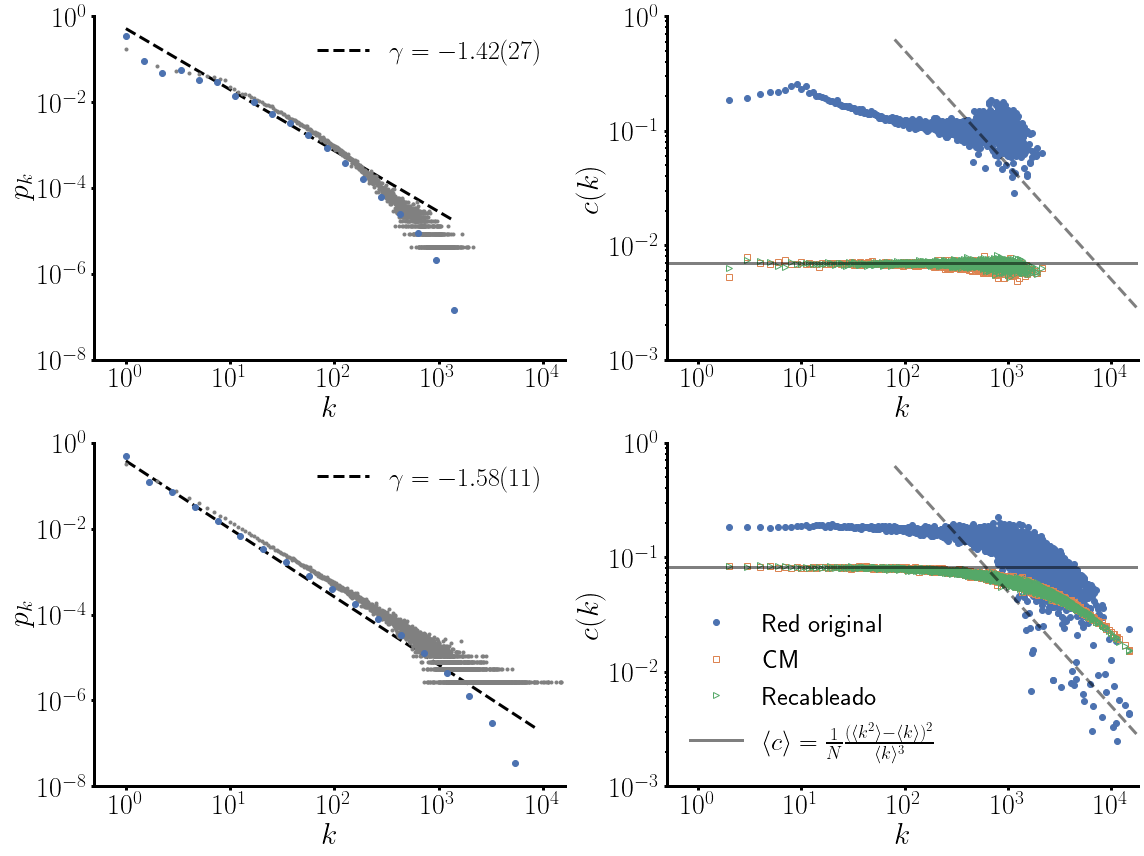

In [21]:
def plot_degree_distribution(data, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xscale("log")
    ax.set_yscale("log")

    # Log scale
    bins = np.logspace(np.log10(min(data)), np.log10(max(data)+1), 20)
    freq, bin_edges = np.histogram(data, bins=bins, density=True)
    X_log, Y_log = bins[:-1], freq

    Y_pred, slope, y_err = linear_regression(X_log[:-3], Y_log[:-3])
    c = Y_log[5] / X_log[5]**slope
    label = r'$\gamma = {{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    ax.plot(
        X_log, powerlaw(X_log, slope, c), "--", color="k", label=label
    )

    # Lin scale
    bins = range(1, max(data)+1)
    freq, bin_edges = np.histogram(data, bins=bins, density=True)
    X_lin, Y_lin = bins[:-1], freq

    ax.plot(X_lin, Y_lin, ".", color="gray")
    ax.plot(X_log, Y_log, "o")
    return ax

def plot_avg_clustering_by_degree(df, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xscale("log")
    ax.set_yscale("log")

    grouped = df.groupby(by="k")["Cws"].mean()
    X = grouped.index
    Y = grouped.values
    marker = kwargs.get("marker", "o")
    fillstyle = kwargs.get("fillstyle", "full")
    label = kwargs.get("label")
    ax.plot(X, Y, marker, fillstyle=fillstyle, label=label)

maxk = max([max(g.degree()) for g in graphs.values()])

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for i, (name, df) in enumerate(dfs.items()):
    ax = axes[i,0]
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$p_k$")
    plot_degree_distribution(df["k"], ax=ax)
    ax.set_xlim(0.5, 1.1*maxk)
    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.set_ylim(1e-8, 1)

    ax = axes[i,1]
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$c(k)$")
    plot_avg_clustering_by_degree(df, ax=ax, label="Red original")
    ax.set_xlim(0.5, 1.2*maxk)
    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.set_ylim(1e-3, 1)



for i, (name, df) in enumerate(dfs_FV.items()):
    ax = axes[i,1]
    label = "CM"
    plot_avg_clustering_by_degree(df, ax=ax, marker="s", fillstyle="none", label=label)


for i, (name, df) in enumerate(dfs_rewired.items()):
    ax = axes[i,1]
    label = "Recableado"
    plot_avg_clustering_by_degree(df, ax=ax, marker=">", fillstyle="none", label=label)
    meank = df.k.mean()
    meank2 = (df.k**2).mean()
    N = len(df)
    xline = (1/N) * (meank2 - meank)**2 / meank**3
    label = r"$\langle c \rangle = \frac{1}{N} \frac{(\langle k^2\rangle - \langle k\rangle)^2}{\langle k \rangle^3}$"
    ax.axhline(xline, color="k", alpha=0.5, label=label)

    X = np.array([80., 20000.])
    Y = powerlaw(X, -1, 50)
    ax.plot(X, Y, linestyle="--", color="k", alpha=0.5)
    ax.set_xlim(0.5, 1.2*maxk)
    ax.set_xticks([1, 10, 100, 1000, 10000])

axes[0,0].legend(frameon=False)
axes[1,0].legend(frameon=False)
axes[1,1].legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig(FIGS_DIR / "figure3.pdf")
plt.show()